## EasyBench Quick Start Notebook 

### Installation

In [ ]:
# Install easybench with visualization support
%pip install -q easybench[all]

### Quick Start

There are 3 ways to benchmark with `easybench`:

#### 1. `@bench` decorator

In [ ]:
from easybench import bench


# Add @bench with function parameters
@bench(item=123, big_list=lambda: list(range(1_000_000)))
def insert_first(item, big_list):
    big_list.insert(0, item)

<div style="background-color: #dff0d8; color: #3c763d; padding: 10px; border-left: 6px solid #5cb85c; margin-bottom: 10px;">
<b>💡 TIP</b><br> 
When you need fresh data for each trial, use a function or lambda to generate new data on demand.  
(like <code>lambda: list(range(1_000_000))</code> in the above)
</div>

#### 2. `EasyBench` class

In [ ]:
from easybench import BenchConfig, EasyBench


class BenchListOperation(EasyBench):
    # Benchmark configuration
    bench_config = BenchConfig(
        trials=10,
        memory=True,
        sort_by="avg",
    )

    # Setup for each trial
    def setup_trial(self):
        self.big_list = list(range(1_000_000))

    # Benchmark methods (must start with bench_)
    def bench_insert_first(self):
        self.big_list.insert(0, 123)

    # You can define multiple benchmark methods
    def bench_pop_first(self):
        self.big_list.pop(0)

if __name__ == "__main__":
    # Run benchmark
    BenchListOperation().bench()

#### 3. `easybench` command

1. Create a `benchmarks` directory

In [ ]:
!mkdir benchmarks

2. Put `bench_*.py` scripts in the directory:

In [ ]:
%%writefile benchmarks/bench_test.py
from easybench import fixture

# Fixture for each trial
@fixture(scope="trial")
def big_list():
    return list(range(1_000_000))

# Benchmark functions (must start with bench_)
def bench_insert_first(big_list):
    big_list.insert(0, 123)

# You can define multiple benchmark functions
def bench_pop_first(big_list):
    big_list.pop(0)

In [ ]:
%%writefile benchmarks/bench_test2.py
from easybench import BenchConfig, EasyBench, customize, fixture


@fixture(scope="trial")
def big_list():
    return list(range(1_000_000))


class BenchList(EasyBench):
    bench_config = BenchConfig(
        memory=True,
        sort_by="avg",
        trials=100,
        warmups=100,
        loops_per_trial=100,
    )

    @customize(loops_per_trial=1000)
    def bench_append(self, big_list):
        big_list.append(-1)

    def bench_insert_first(self, big_list):
        big_list.insert(0, -1)

    def bench_insert_middle(self, big_list):
        big_list.insert(len(big_list) // 2, -1)

    @customize(loops_per_trial=1000)
    def bench_pop(self, big_list):
        big_list.pop()

    def bench_pop_zero(self, big_list):
        big_list.pop(0)


if __name__ == "__main__":
    BenchList().bench()

3. Run `easybench` command

In [ ]:
!easybench --trials 10 --memory --sort-by avg --no-progress

---

### Visualization Sample

Benchmarking:   0%|          | 0/5 [00:00<?, ?it/s]

Function: bench_append:   0%|          | 0/200 [00:00<?, ?it/s]

Function: bench_insert_start:   0%|          | 0/200 [00:00<?, ?it/s]

Function: bench_insert_middle:   0%|          | 0/200 [00:00<?, ?it/s]

Function: bench_pop:   0%|          | 0/200 [00:00<?, ?it/s]

Function: bench_pop_zero:   0%|          | 0/200 [00:00<?, ?it/s]


Benchmark Results (100 trials):

Function               Avg Time (s)  Min Time (s)  Max Time (s)
---------------------------------------------------------------
bench_append               0.000001      0.000001      0.000005
bench_insert_start         0.001312      0.000746      0.004510
bench_insert_middle        0.000386      0.000230      0.000913
bench_pop                  0.000000      0.000000      0.000002
bench_pop_zero             0.001146      0.000688      0.002957


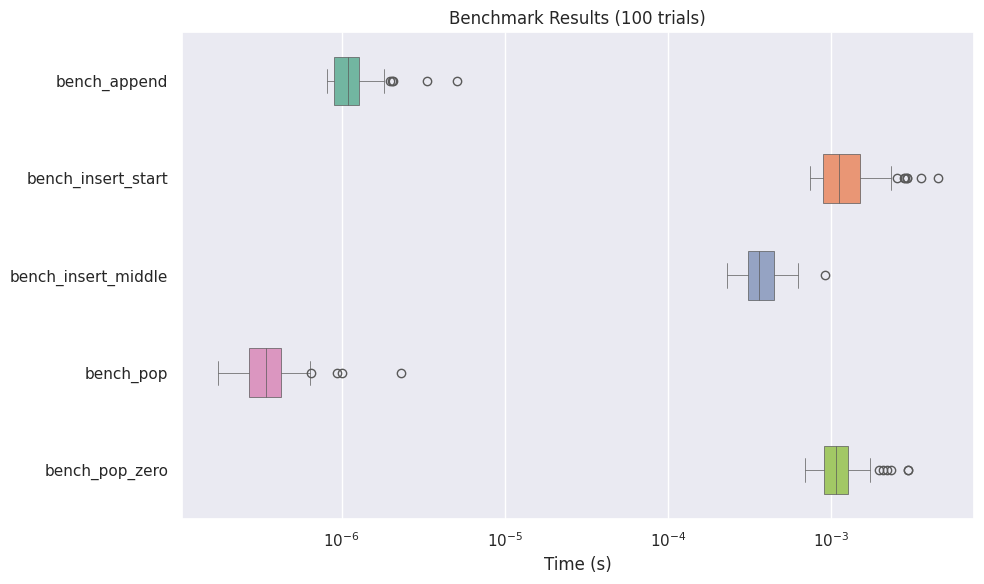

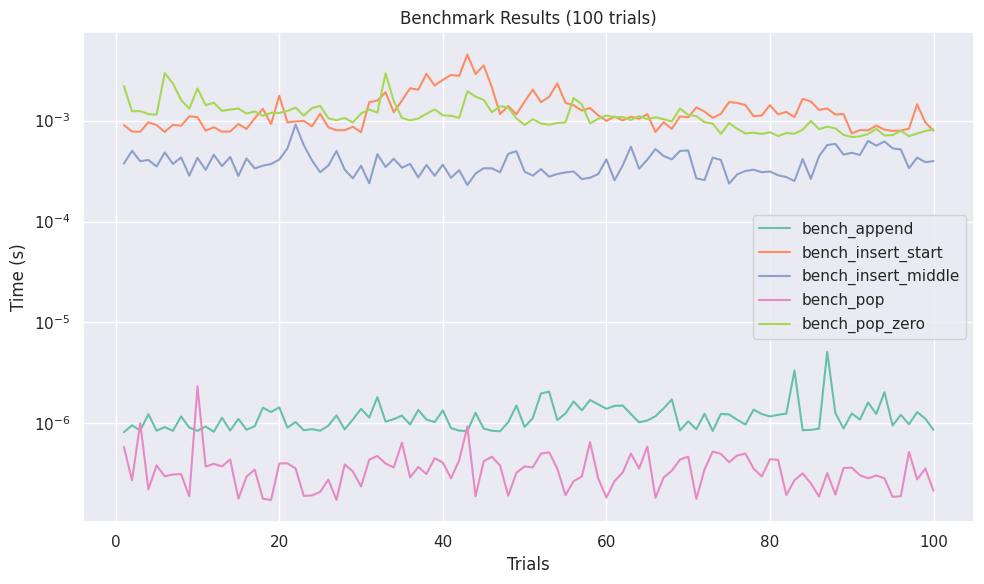

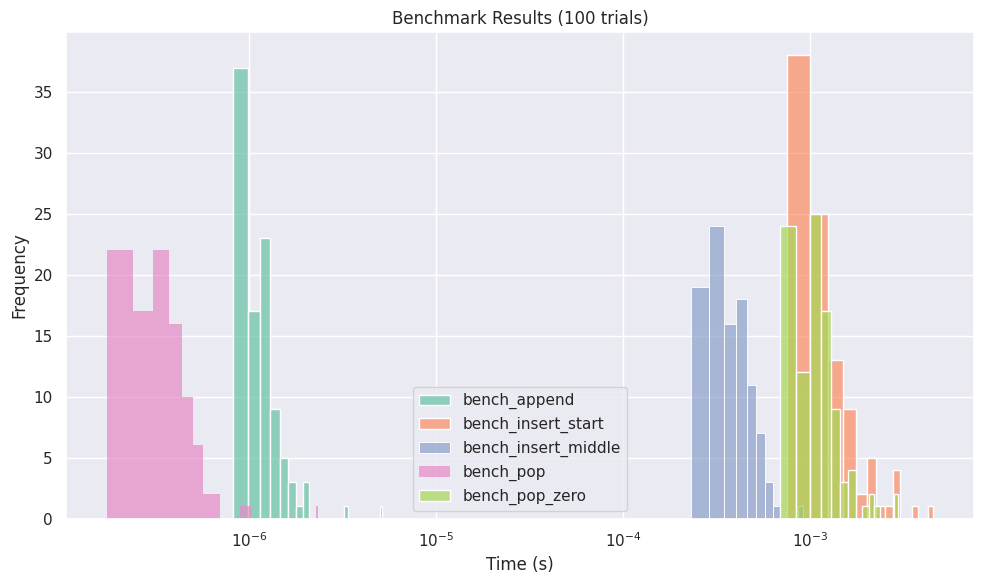

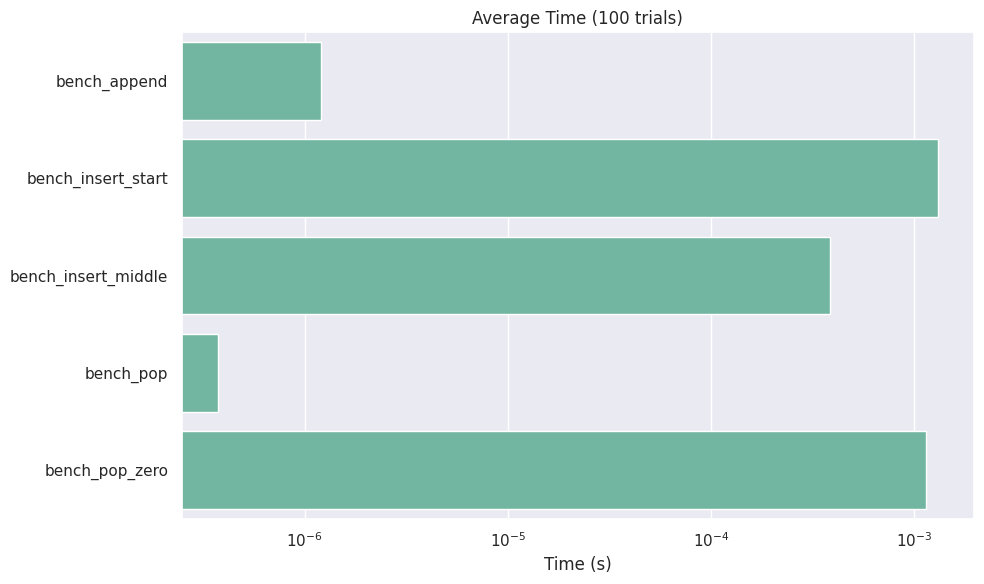

In [1]:
from easybench import BenchConfig, EasyBench, customize
from easybench.visualization import BoxPlotFormatter, PlotReporter


class BenchList(EasyBench):
    bench_config = BenchConfig(
        trials=100,
        warmups=100,
        loops_per_trial=100,
        progress=True,
        reporters=[
            "console",                              # Display results on console
            PlotReporter(
                BoxPlotFormatter(
                    showfliers=True,                # Show outliers
                    log_scale=True,                 # Use logarithmic scale
                    engine="seaborn",               # Use seaborn as plotting engine
                    orientation="horizontal",       # Horizontal or vertical orientation
                    width=0.5,                      # Box width (passed directly to seaborn's boxplot)
                    linewidth=0.5,                  # Line width (passed directly to seaborn's boxplot)
                ),
            ),
            ("lineplot-sns", {"log_scale": True}),  # Shorthand notation for LinePlotFormatter
            ("histplot-sns", {"log_scale": True}),
            ("barplot-sns", {"log_scale": True}),
        ],
    )

    def setup_trial(self):
        self.big_list = list(range(1_000_000))

    @customize(loops_per_trial=1000)
    def bench_append(self):
        self.big_list.append(-1)

    def bench_insert_start(self):
        self.big_list.insert(0, -1)

    def bench_insert_middle(self):
        self.big_list.insert(len(self.big_list) // 2, -1)

    @customize(loops_per_trial=1000)
    def bench_pop(self):
        self.big_list.pop()

    def bench_pop_zero(self):
        self.big_list.pop(0)


if __name__ == "__main__":
    BenchList().bench()